In [ ]:
# | hide
# | default_exp functional
import nbdev
from nbdev.showdoc import *

nbdev.nbdev_export()

# 🔸 Functional operations


In [ ]:
# | exporti
import numpy as np
from tidygrad.tensor import Tensor, UnaryElementwiseOp, BinaryElementwiseOp, BaseOp, ExpLog

In [ ]:
# | exporti
class Sigmoid(UnaryElementwiseOp):
    """Take the sigmoid of a tensor"""
    name_template = "sigmoid({})"

    def __init__(self, a, name=None):
        super().__init__(a, name=name)
        self.out = Tensor(1 / (1 + np.exp(-self.args[0].data)), name=self.name, op=self)

    def backward(self):
        with np.errstate(under="ignore"):  # Triggered by infinitesimally small 1-data
            self.parents[0].grad += self.out.grad * self.out.data * (1 - self.out.data)

In [ ]:
# | export
def sigmoid(input, name=None):
    return Sigmoid(input, name=name).out

In [ ]:
#| export
def softmax(input, name=None):
    exp = input.exp()
    return exp.div(exp.sum(axis=-1, keepdims=True), name=name)

In [ ]:
# | exporti
class Relu(UnaryElementwiseOp):
    """Take the sigmoid of a tensor"""

    name_template = "relu({})"

    def __init__(self, a, name=None):
        super().__init__(a, name=name)
        self.out = Tensor(np.maximum(0, self.args[0].data), name=self.name, op=self)

    def backward(self):
        self.parents[0].grad += self.out.grad * (self.out.data > 0)

In [ ]:
# | export
def relu(input, name=None):
    return Relu(input, name=name).out

In [ ]:
# | export
def BCE_loss(logits: Tensor, target: Tensor, reduction="mean"):
    loss = logits - logits*target + ExpLog(-logits).out
    if reduction == "mean": return loss.mean()
    if reduction == "sum": return loss.sum()
    assert 0, "Invalid reduction"

In [ ]:
#| export

def CrossEntropy_loss(logits: Tensor, target: Tensor, reduction="mean"):
    if not isinstance(target, Tensor): target = Tensor(target)
    sm = softmax(logits)
    loss = -target * sm.log()
    if reduction == "mean": return loss.mean()
    if reduction == "sum": return loss.sum()
    assert 0, "Invalid reduction"

In [ ]:
# | exporti
class Dropout(UnaryElementwiseOp):
    """Apply Dropout to a tensor"""

    name_template = "dropout({})"

    def __init__(self, a, p_drop=0.1, training=True, name=None):
        super().__init__(a, name=name)
        assert 0 < p_drop < 1, f"p_drop must in (0, 1), got {p_drop}"
        self.p_drop = p_drop
        self.training = training
        if training:
            # Note: We scale up the outputs during training rather than scaling down during inference.
            scale_factor = 1 / (1-p_drop)
            self.mask = np.random.binomial(scale_factor, 1 - p_drop, size=self.args[0].data.shape)
            self.out = Tensor(self.args[0].data * self.mask, name=self.name, op=self)
        else:
            self.out = Tensor(self.args[0].data, name=self.name, op=self)

    def backward(self):
        self.parents[0].grad += self.out.grad * (self.mask if self.training else 1)

In [ ]:
# | export
def dropout(x, p=0.5, training=True):
    if p == 0:
        return x

    return Dropout(x, p_drop=p, training=training).out

### 🔹 Convolution

In [ ]:
#| export

from typing import Union, Tuple

In [ ]:
# def np_pad(a: np.ndarray, padSize: Union[int, Tuple[int, int]]) -> np.ndarray:
#     ny, nx = padSize if isinstance(padSize, tuple) else (padSize, padSize)
#     pad_widths = [(0, 0)] * (a.ndim - 2) + [(ny, ny), (nx, nx)]
#     return np.pad(a, pad_widths, mode="constant")

# def np_unpad(a: np.ndarray, padSize: Union[int, Tuple[int, int]]) -> np.ndarray:
#     ny, nx = padSize if isinstance(padSize, tuple) else (padSize, padSize)
#     return a[..., ny:-ny, nx:-nx]

# def region_from_padded(A: np.ndarray, r: int, c: int, kernel_shape: Union[int, Tuple[int, int]]) -> np.ndarray:
#     ky, kx = kernel_shape if isinstance(kernel_shape, tuple) else (kernel_shape, kernel_shape)
#     slices = (slice(None),) * (A.ndim - 2) + (slice(r, r + ky), slice(c, c + kx))
#     return A[slices]

def np_pad(a: np.ndarray, pad: Tuple[int, int]) -> np.ndarray:
    h, w = pad
    pad_widths = [(0, 0)] * (a.ndim - 2) + [(h, h), (w, w)]
    return np.pad(a, pad_widths, mode="constant")

def np_unpad(a: np.ndarray, padSize: Tuple[int, int]) -> np.ndarray:
    h, w = padSize
    return a[..., h:-h, w:-w]

def region_from_padded(A: np.ndarray, r: int, c: int, kernel_shape: Tuple[int, int]) -> np.ndarray:
    '''
    pulls out a 'kernel' sized region from a padded array, centered on (r, c)
    '''
    ky, kx = kernel_shape
    slices = (slice(None),) * (A.ndim - 2) + (slice(r, r + ky), slice(c, c + kx))
    return A[slices]

In [ ]:
# Updated test for np_pad
A = np.array([[1, 2], [3, 4]])
pad_A = np_pad(A, (1, 1))
assert np.array_equal(pad_A, [[0, 0, 0, 0], [0, 1, 2, 0], [0, 3, 4, 0], [0, 0, 0, 0]])
A_recovered = np_unpad(pad_A, (1, 1))
assert np.array_equal(A, A_recovered)
region = region_from_padded(pad_A, 0, 0, kernel_shape=(3, 3))
assert region.shape == (3, 3) and region[1,1] == 1

In [ ]:

#| export
class Pad(UnaryElementwiseOp):
    """Pad a tensor"""
    name_template = "pad2d({})"

    def __init__(self, a, padding: Union[int, Tuple[int, int]], name=None):
        super().__init__(a, name=name)
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        self.out = Tensor(np_pad(a.data, self.padding), name=self.name, op=self)

    def backward(self):
        self.parents[0].grad += np_unpad(self.out.grad, self.padding)
        # pY, pX = self.padding
        # slices = (slice(None),) * (len(self.args[0].shape) - 2) \
        #     + (slice(pY, -pY),) + (slice(pX, -pX),)
        # self.parents[0].grad += self.out.grad[slices]

In [ ]:
from matplotlib import pyplot as plt

<matplotlib.image.AxesImage>

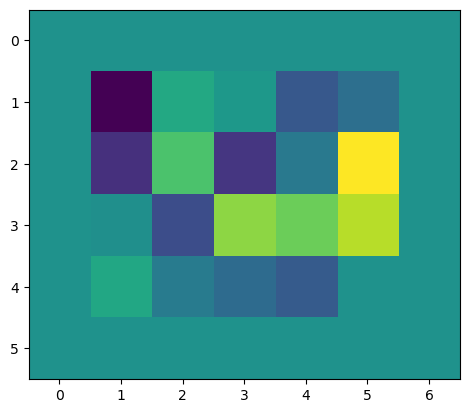

In [ ]:
x = Tensor(np.random.randn(1, 1, 4, 5), name="x")
bias = Pad(x, 1).out

plt.imshow(bias.data[0, 0, :, :])

In [ ]:

def np_conv2d(padded_input:np.ndarray, kernel:np.ndarray, bias:np.ndarray):
    batch, input_channels, input_height, input_width = padded_input.shape
    output_channels, _input_channels, kernel_height, kernel_width = kernel.shape

    assert kernel_height % 2 == 1, "Only odd kernel sizes are supported for"
    assert kernel_width % 2 == 1, "Only odd kernel sizes are supported for"

    assert input_channels == _input_channels, f"Input channels mismatch: {input_channels} != {_input_channels}"
    assert bias.shape == (output_channels, ), f"Invalid bias shape: {bias.shape}"

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    y = np.zeros((batch, output_channels, output_height, output_width), dtype=padded_input.dtype)
    for r in range(output_height):
        for c in range(output_width):
            region = region_from_padded(padded_input, r, c, (kernel_height, kernel_width))
            y[:, :, r, c] = np.sum(region * kernel + bias, axis=(-1, -2))
    return y

def np_kernel_grad(padded_input:np.ndarray, kernel:np.ndarray, bias:np.ndarray, grad:np.ndarray):
    batch, input_channels, input_height, input_width = padded_input.shape
    output_channels, _input_channels, kernel_height, kernel_width = kernel.shape

    assert kernel_height % 2 == 1, "Only odd kernel sizes are supported for"
    assert kernel_width % 2 == 1, "Only odd kernel sizes are supported for"

    assert input_channels == _input_channels, f"Input channels mismatch: {input_channels} != {_input_channels}"
    assert bias.shape == (output_channels, ), f"Invalid bias shape: {bias.shape}"

    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1

    # padded_input  # [ batch, input_channels, input_height, input_width
    # kernel        # [ output_channels, input_channels, kernel_height, kernel_width ]
    # grad          # [ batch, output_channels, output_height, output_width ]

    assert kernel_width == kernel_height, "Only square kernels are supported for now"

    assert grad.shape[-2:] == (output_height, output_width), f"Invalid grad shape: {grad.shape}"

    grad_w = np.zeros_like(kernel)
    for r in range(output_height):
        for c in range(output_width):
            p0 = region_from_padded(padded_input, r, c, (kernel_height, kernel_width))
            p = padded_input[:, :, r:r + kernel_height, c:c + kernel_width]
            assert np.allclose(p0, p)

            for ch in range(0, output_channels):
                q = grad[:, ch, r, c]
                # q = q[:, None, None]  # <-- don't need this
                grad_w[ch,:,:,:] += (p * q).sum(axis=0)

    return grad_w

### Relationship Between Padding, Kernel Size, and Deconvolution

For a convolution operation, given:

- Input size $N$
- Kernel size $k$ (where $k \leq N$)
- Padding $p$ (applied symmetrically on all sides)

The padded input will have a size of $N + 2p$.

After applying the convolution with the kernel, the output $y$ will have a size:

$$
N_y = N + 2p - k + 1
$$

#### Back to Input Domain (Deconvolution)

Before convolving back to the input domain, we apply a new padding $p'$ (unknown at this point) to $N_y$, resulting in a length of $N_y + 2p'$.

After the deconvolution, we get:

$$
(N_y + 2p') - k + 1 = N + 2p - k + 1 + 2p' - k + 1
$$

Simplifying, we find:

$$
N + 2(p + p') - 2k + 2 = N
2(p + p') - 2k + 2 = 0
p + p' = k - 1
p' = k - p - 1
$$

This equation gives us the value of $p'$ required to get back to the input domain size $N$ after deconvolution.

---

In [ ]:
class Conv2D(BaseOp):
    def __init__(self, input, kernel, bias, stride=1, padding=0, name=None):
        super().__init__(input, kernel, bias, name=name)
        self.stride = stride
        assert stride == 1, "Only stride=1 is supported for now"
        # assert padding == 1, "Only padding=1 is supported for now"

        # self.padding = ((kernel.data.shape[-2] - 1) // 2, (kernel.data.shape[-1] - 1) // 2)  \
        #     if padding is None else (padding, padding) if isinstance(padding, int) else padding
        self.padding = (padding, padding) if isinstance(padding, int) else padding

        self.parents = [*self.args]

        self.input_data_padded = np_pad(self.args[0].data, self.padding)

        data = np_conv2d(self.input_data_padded, kernel.data, bias.data)

        self.out = Tensor(data, name=self.name, op=self)

    def backward(self):
        rot180 = lambda x: np.rot90(x, 2)

        input_, kernel, bias = self.args
        grad = self.out.grad

        pad_h = kernel.data.shape[-2] - self.padding[0] - 1
        pad_w = kernel.data.shape[-1] - self.padding[1] - 1
        padded_grad = np_pad(grad, (pad_h, pad_w))

        input_.grad += np_conv2d(padded_grad, rot180(kernel.data), np.zeros_like(bias.data))

        kernel.grad += np_kernel_grad(self.input_data_padded, kernel.data, bias.data, grad)

In [ ]:
from tidygrad.utils.grad_check import grad_check

In [ ]:
x = Tensor(np.eye(5)[None, None], "x")
kernel = Tensor(np.eye(3).reshape(1, 1, 3, 3), "w")
bias = Tensor(np.zeros((1, )), "b")

# conv = Conv2D(x, kernel, bias, padding=1).out
# loss = conv.mean()
# loss.backward()

def func(inputs, params):
    x, kernel = params
    bias = Tensor(np.zeros((1,)), "b")
    return Conv2D(x, kernel, bias).out.mean()

func(None, (x, kernel)).backward()

grad_check(func, None, (x,kernel))

Max gradient difference for w: 0.0000%
Max gradient difference for x: 0.0000%


In [ ]:
from tidygrad.utils.datasets import MNIST

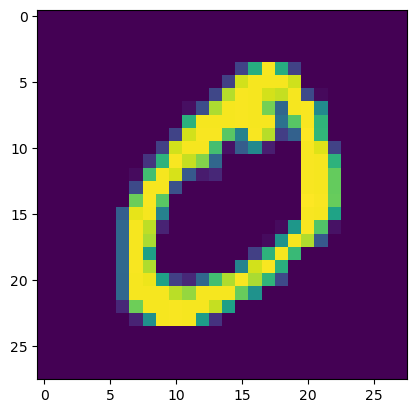

<matplotlib.image.AxesImage>

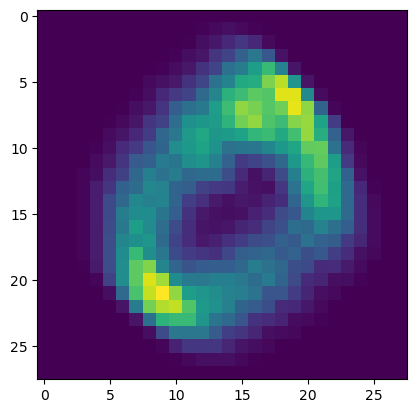

In [ ]:

mnist = MNIST()

x = Tensor(mnist[1][0][None][None], "x")
plt.show(plt.imshow(x.data[0, 0]))

conv = Conv2D(x, kernel, bias, padding=1).out
conv = Conv2D(conv, kernel, bias, padding=1).out
conv = Conv2D(conv, kernel, bias, padding=1).out
plt.imshow(conv.data[0, 0, :, :])